In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

Classificação:
 - ROC, matriz de confusão, accuracy
 
Regressão:
 - RMSE

# MNIST

A base de dados que utilizaremos é conhecida como MNIST ("Modified National Institute of Standards and Technology"), e deriva de uma base maior que foi construida pela NIST nos Estados Unidos (o equivalente da nossa ABNT). Esta base de dados é considerada o verdadeiro "Hello, world!" de métodos de classificação. Em http://yann.lecun.com/exdb/mnist/ temos uma descrição mais detalhada desta base de dados.

**Atividade**: 
    
Leia a página de descrição do MNIST supracitada, e responda:

- Quantas imagens de treinamento e quantas imagens de teste existem na MNIST?

- Qual o tamanho de cada imagem no MNIST?

- Os criadores da MNIST tiveram um cuidado especial ao construir os conjuntos de treinamento e teste, em relação às pessoas que escreveram os dígitos. Que cuidado foi esse, e por que foi adotado?

- As imagens foram construidas escaneando digitos manuscritos, que foram escritos por dois grupos de pessoas: alunos de colegial (SD-1) e funcionários da NIST (SD-3). Originalmente a NIST designou SD-3 como o conjunto de teste, e SD-1 como o conjunto de treinamento. Os criadores da MNIST criticaram essa decisão e resolveram misturar os conjuntos. Por que? Como esta situação difere daquela da pergunta anterior?

- A página lista vários artigos que exploraram métodos de classificação no MNIST, com seus respectivos desempenhos. Qual o método com o pior desempenho (e qual foi esse desempenho)? Qual o método com o melhor desempenho, e de quanto foi?

**R:**

- Set de treinamento com 60000 imagens e set de teste com 10000 imagens. 
- As imagens possuem tamanho de 28x28 pixels;
- "The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint." Garante, com isso, que o algoritmo não acerte um resultado na base de teste porque ele possuia a mesma caligrafia (mesmo escritor) de algum número da base de treinamento.
- "NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets." Como indica o trecho, os dois datasets foram misturados para formar o novo dataset, devido a facilidade de se reconhecer imagens do SD-3 do que do SD-1. Se difere porque foram separações distintas. O primeiro cuidado foi feito para evitar resultados "falsos" (por já conhecer tal caligrafia) quando o algoritmo for usado na base de teste. Essa divisão foi feita para tornar o dataset mais misturado.
- Método com pior desempenho: ```linear```, sem pré-processamento (12% de erros).
- Método com melhor desempenho: ```committee of 35 conv. net, 1-20-P-40-P-150-10 [elastic distortions]```, com normalização (0.23% de erros).


O scikit-learn já tem ferramentas para baixar e disponibilizar alguns dos datasets mais comuns da comunidade de machine learning:

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([5, 0, 4, ..., 4, 5, 6], dtype=int8))

No campo 'data' temos as várias imagens de dígitos manuscritos. Cada item é uma lista de $28^2 = 784$ valores.

No campo 'target' temos o rótulo de cada uma dessas imagens.

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Vamos ver um desses dígitos manuscritos para checar se a leitura de dados funcionou:

label: 5


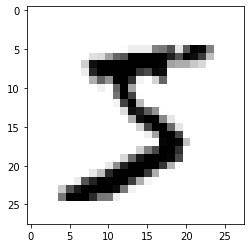

In [4]:
some_digit = X[0]
some_digit_label = y[0]

print('label: {}'.format(some_digit_label))

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()

Parece que deu certo: pela imagem trata-se de um dígito $5$ manuscrito, e de fato o rótulo confirma essa observação.

# Separando treinamento e teste

Conforme visto na descrição do dataset MNIST, a separação entre conjunto de treinamento e teste já está feita. Neste caso, não devemos fazer a separação dos dados conforme visto na aula passada. 

In [5]:
unique, counts = np.unique(mnist['target'][:60000], return_counts=True)
for u, c in zip(unique, counts):
    print('{}: {}'.format(u,c))

0: 5923
1: 6742
2: 5958
3: 6131
4: 5842
5: 5421
6: 5918
7: 6265
8: 5851
9: 5949


Os primeiros 60000 exemplos são o conjunto de treinamento, e estão organizados por dígito. Os últimos 10000 exemplos são o conjunto de teste, e também estão organizados por dígito.

In [6]:
X_train = X[:60000]
y_train = y[:60000]

X_test = X[60000:]
y_test = y[60000:]

Vamos ver mais alguns digitos desta base:

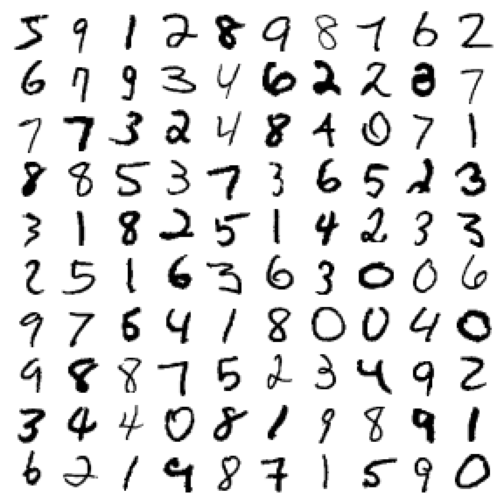

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    """Plota uma lista de imagens do MNIST em um formato de matriz de imagens.
    
    Keywords:
    instances -- Lista de linhas da matriz de amostras do MNIST.
    images_per_row -- Número de imagens por linha.
    options -- Opções passadas ao comando plt.imshow() para desenho.
    """
    # Tamanho das imagens no MNIST: 28 x 28.
    size = 28

    # Monta uma lista de imagens usando list comprehension e np.reshape().
    # Cada item da lista resultante é uma imagem 28 x 28.
    images = [instance.reshape(size,size) for instance in instances]
    
    # Caso o número de imagens por linha seja muito grande, 
    # limite no número de imagens disponível.
    images_per_row = min(len(instances), images_per_row)

    # Dado o número de imagens por linha, calcule quantas linhas
    # são necessárias.
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Truque: cria uma imagem em branco de tamanho suficiente para preencher
    # o espaço em branco no final da ultima linha, e coloca essa imagem
    # em branco na lista de imagens.
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    # Cria uma imagem unificada por linha.
    row_images = []
    for row in range(n_rows):
        # Junta imagens da linha em uma imagem unificada, e coloca na 
        # lista de imagens de linha.
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))

    # Junta todas as imagens de linha em uma unica imagem final.
    image = np.concatenate(row_images, axis=0)
    
    # Mostra a imagem final.
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

# Classificação binária

Vamos começar com um problema mais simples: classificar os dígitos da base em 'cincos' e 'não-cincos'. Este é um problema de classificação binária. Por mera convenção, chamaremos de 'amostras positivas', ou simplemente 'positivos' os digitos $5$ e de 'negativos' os demais dígitos.

Vamos adaptar os conjuntos de treinamento e teste ao nosso cenário:

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Verificando se funcionou:

In [9]:
n = 20
for original, binarized in zip(y_train[:n], y_train_5[:n]):
    print('{} -> {}'.format(original, binarized))

5 -> True
0 -> False
4 -> False
1 -> False
9 -> False
2 -> False
1 -> False
3 -> False
1 -> False
4 -> False
3 -> False
5 -> True
3 -> False
6 -> False
1 -> False
7 -> False
2 -> False
8 -> False
6 -> False
9 -> False


Vamos agora treinar um classificador sobre todo o conjunto de treinamento, como fizemos na aula sobre regressão. Vamos usar um classificador chamado de *Stochastic Gradient Descent*, que é uma generalização de alguns tipos diferentes de classificadores mais tradicionais. O scikit-learn tem uma classe que implementa este classificador: `SGDClassifier`. Com os parâmetros default desta classe, o classificador SGD é equivalente a um classificador do tipo "máquina de vetores de suporte linear".

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=500, tol=1e-3, random_state=RANDOM_SEED)  # Existe aleatoriedade dentro do SGDClassifier.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=500, random_state=42)

Vamos testar o classificador naquele dígito $5$ que a gente tinha visualizado no começo do notebook:

In [11]:
sgd_clf.predict([some_digit])

array([ True])

Perfeito, ele acertou! Mas isso foi apenas um exemplo, vamos agora estudar o desempenho do classificador.

# Métricas de desempenho

## Usando validação cruzada

Assim como na aula anterior, podemos usar a estratégia da validação cruzada para tentar inferir o desempenho do nosso classificador no mundo real:

In [12]:
import time
from sklearn.model_selection import cross_val_score

t1 = time.process_time()
res = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)
t2 = time.process_time()

print('Elapsed time: {}'.format(t2 - t1))
print(res)

Elapsed time: 0.515625
[0.95035 0.96035 0.9604 ]


A medida usada é o *accuracy* (acurácia), que é a porcentagem de acertos de previsão. Obtivemos 96%! Parece excelente, mas será mesmo? Compare com o "classificador" a seguir:

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        # Nada a ser feito no treinamento.
        pass

    def predict(self, X):
        # Recebe len(X) amostras, chuta "False" como resposta para todas!
        return [False] * len(X)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

**Pergunta:** Parece que atingir 90% não é nada difícil neste problema... na verdade, é o esperado! Explique porque.

**R:** Selecionando uma amostra aleatória, é esperado que a distribuição de cada digito na amostra seja de 10%, pois temos digitos de 0-9. 
Assim, se "chutarmos" que não existe nenhum 5 na nossa amostra (como no exemplo acima), esperamos errar apenas 10% das vezes, dado que esse digito tende a representar 10% do que foi analisado.

## Matriz de confusão

Uma forma muito interessante de se avaliar o desempenho de um classificador é obter a matriz de confusão (*confusion matrix*) do classificador. Nesta matriz cada linha representa a categoria *verdadeira* de um objeto, e cada coluna representa a categoria *predita* de um objeto. Uma posição $(r,c)$ da matriz de confusão representa, portanto, o número de objetos que pertencem verdadeiramente à categoria $r$, mas que foram classificados como pertencentes à categoria $c$ por nosso classificador. 

![Matriz de confusão](confusao.png "Matriz de confusão")

As células da diagonal, em verde, mostram as posições onde a classe verdadeira e a classe predita coincidem, esses são os acertos. As células fora da diagonal, em azul, são os erros.

Podemos calcular a matriz de confusão resultante do treinamento sobre o conjunto (de treinamento) completo:

In [15]:
from sklearn.metrics import confusion_matrix

sgd_clf.fit(X_train, y_train_5)
y_train_pred = sgd_clf.predict(X_train)
mat = confusion_matrix(y_train_5, y_train_pred)
mat

array([[52316,  2263],
       [  601,  4820]], dtype=int64)

Porém o desempenho exibido por este processo é muito otimista, e não representa uma estimativa realista dos erros deste classificador no mundo real.

**Pergunta:** Em caso de overfitting total, como ficaria a matriz de confusão?

**R:** Só haveriam resultados na diagonal principal.
```
[[54000, 0]
 [0, 6000]]
```

Uma idéia melhor é aplicar o conceito de validação cruzada para realizar a predição de cada amostra. Funciona assim:

- Particionamos os dados em N partições.

- Para cada partição:

    - Treinamos o classificador sobre os dados das outras partições
    
    - Usamos o classificador para prever as classes das amostras desta partição

Por exemplo: suponha que temos 3 partições. As categorias preditas dos objetos da primeira partição são obtidas da seguinte forma:

- Treinamos o classificador usando os dados das partições 2 e 3

- Aplicamos o classificador para os objetos da partição 1. Guardamos estes resultados

Fazemos o mesmo para os objetos das partições 2 e 3. Desta forma, cada objeto foi predito de modo "honesto", ou seja, usando um classificador que não continha o próprio objeto como dado de treinamento!

O scikit-learn já tem uma função para fazer exatamente isso: `cross_val_predict`

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

Agora podemos observar uma matriz de confusão mais realista:

In [17]:
mat = confusion_matrix(y_train_5, y_train_pred)
mat

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Não mudou muito, mas tudo bem: esses números são mais confiáveis. Significa que nosso modelo não é muito inclinado a ter overfitting nesse problema em particular!

Nesta matriz de confusão a primeira linha indica dígitos "não-cinco", e a segunda linha indica os dígitos "cinco". Em problemas de classificação binária usamos a terminologia "negativos" (os "não-cinco") e "positivos" (os "cinco"), e dizemos também que nosso problema é "detectar" os dígitos "cinco".

- **TP**: Os valores **verdadeiramente positivos** e que foram **preditos como positivos** são os **true positives** (verdadeiros positivos).

- **FN**: Os valores **verdadeiramente positivos** e que foram **preditos como negativos** são os **false negatives** (falsos negativos, pois foram errôneamente classificados como negativos).

- **TN**: Os valores **verdadeiramente negativos** e que foram **preditos como negativos** são os **true negatives** (verdadeiros negativos).

- **FP**: os valores **verdadeiramente negativos** e que foram **preditos como positivos** são os **false positives** (falsos positivos, pois foram errôneamente classificados como positivos).

![Precision-recall](precision_recall.png "Precision and recall")

**Perguntas:**

- Dê um exemplo real de falso positivo.

- Dê um exemplo real de falso negativo.

- Nesta matriz exemplo, qual é a acurácia?

**R:**

Falso positivo: 
- O teste acusar que alguém está com covid-19, quando a pessoa não está infectada pelo virus.
- Contratei alguém que mandou bem no processo seletivo, mas na prática não teve desempenho desejado no trabalho.

Falso negativo: 
- O teste acusar que alguém não está com covid-19, quando a pessoa está infectada pelo virus.

Acurácia: 8/11;

Acurácia na matriz abaixo: 57422/60000

```
[53892,  687]
[1891,  3530]

```
            


## Precision e recall

A medida de acurácia não permite distinguir entre os tipos de erro. Duas medidas mais comuns que são empregadas em machine learning são a **precision** (precisão) e **recall** (revocação), definidas como:

- Precision: Dentre os elementos classificados como positivos, quantos realmente são positivos?

$$\text{precision} = \frac{TP}{TP + FP}$$

- Recall: Dentre os elementos verdadeiramente positivos, quantos foram detectados como positivos?

$$\text{recall} = \frac{TP}{TP + FN}$$

**Perguntas:** 

- É sempre possível construir um classificador com recall 100%. Como? E o que acontece com o precision?

- Qual o precision e o recall do Never5Classifier?

**R:** 

Zerando os casos de FN. Fazendo com que isso aconteça, precision vai diminuir, pois ele nunca retornaria negativo, todos seriam positivos. --> caso do ```always5classifier```

never5classifier possui uma precision de 0% e recall de 0%, pois não possui TPs.

Para calcular o precision e o recall no scikit-learn:

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


**Atividade:** Confirme se o scikit-learn acertou baseado na matriz de confusão.

In [19]:
print(f'precision: {3530/(3530+687)}')
print(f'recall: {3530/(3530+1891)}')

precision: 0.8370879772350012
recall: 0.6511713705958311


A métrica $F_1$ serve para combinar o precision e o recall em uma métrica única que valoriza o equilibrio entre estas duas medidas. É definida como a média harmônica do precision e do recall:


$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$$

No scikit-learn:

In [20]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


O valor de $F_1$ tende a favorecer precision e recall balanceados. Isto não é necessariamente bom, existem situações em que você quer favorecer um ou outro.

**Perguntas:**

- Dê um exemplo de situação onde precision é melhor que recall.

- Dê um exemplo de situação onde recall é melhor que precision.

**R:** 

precision é melhor que recall em casos em que devemos ser mais precisos, por exemplo decidir se um paciente deve iniciar um tratamento agressivo de quimioterapia.

recall é melhor que precision em casos de teste de doenças (melhor ter pessoa não doente sendo tratadas - de uma forma não agressiva - , do que não doentes sendo liberadas/não tratadas), ou recall de carros (todos os carros de tal lote ou série de fábrica devem passar por revisões para garantir perfeito funcionamento...)

### Precision/recall tradeoff

Seria muito bom se tivéssemos um classificador com precision 100% e recall 100%, seria um classificador perfeito!

Infelizmente o mundo real não é assim: quanto maior o precision menor o recall, e vice versa. Para entender isso melhor temos que conhecer um pouco mais a fundo como nosso classificador (SGD) funciona.

Dentro do SGDClassifier, o primeiro passo da predição é calcular um valor para a amostra sobre a qual estamos fazendo a predição. Veremos em aulas subsequentes como isso funciona. Quanto maior o valor, mais provável é que a amostra seja positiva. Esta função que se aplica inicialmente chama-se "função de decisão" (decision function). 

Em seguida, usamos um parâmetro do classificador chamado de valor de limiar (threshold). Se o valor da função de decisão estiver acima do threshold, a amostra é classificada como positiva. Caso contrário, será classificada como negativa. 

<img src="decision_function.png" alt="função de decisão" style="width: 800px;"/>

**Perguntas:**

- O que acontece se o threshold for muito, muito baixo? Como ficam os valores de precision e recall?

- O que acontece se o threshold for muito, muito alto? Como ficam os valores de precision e recall?

- Prove que se o precision e o recall são $100\%$ temos um classificador que não erra.

**R:**

Threshold baixo: maior recall, pois teremos mais amostras classificadas como positivas.

Threshold alto: maior precision, pois teremos menos amostras classificadas como positivas (logo a chance de errar e ter um FP é menor).

acuracia = (TP + TN)/(TP + TN + FP + FN) => se FP e FN = 0 => acc = (TP + TN)/(TP + TN) = 1 = 100%. 


Podemos observar os valores da função de decisão calculados para nossas amostras de treinamento usando o scikit-learn: basta adicionar um parâmetro extra à chamada de `cross_val_predict`:

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function", n_jobs=-1)

Vamos agora plotar os valores de precision e recall juntos em uma curva única:

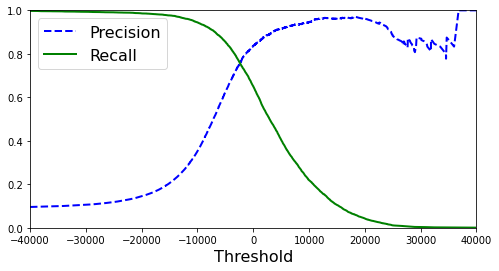

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlim([-40000, 40000])
plt.ylim([0, 1])
plt.show()

O que essa curva significa? Significa que podemos ter qualquer valor de precision que quisermos, mas isso mexe no recall, e vice versa! 

Por exemplo: suponha que queremos um precision de 90% - queremos que nosso classificador esteja muito seguro de que achou um dígito 5. Como já temos os valores da função de decisão (`y_scores`), basta aplicar um threshold alto para ter um classificador de alta precisão! Olhando na curva acima, vemos que um threshold de aproximadamente 8000 deve servir:

In [23]:
y_train_pred_90 = (y_scores > 8000)

Vamos medir o precision e o recall deste classificador:

In [24]:
print('Precision: {}'.format(precision_score(y_train_5, y_train_pred_90)))
print('Recall: {}'.format(recall_score(y_train_5, y_train_pred_90)))

Precision: 0.9346130773845231
Recall: 0.2874008485519277


Aumentamos o precision para aproximadamente 90%, mas o recall caiu.

Se estivermos interessados em observar apenas o compromisso entre precision e recall, podemos diagramar um contra o outro:

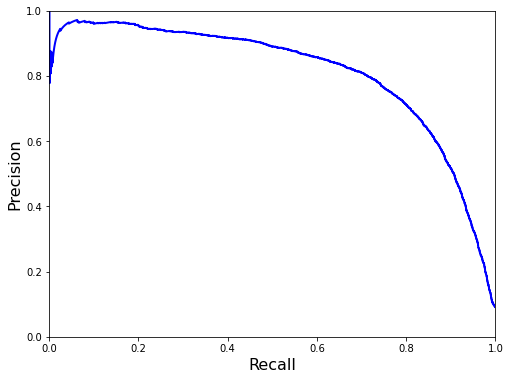

In [25]:
plt.figure(figsize=(8, 6))

plt.plot(recalls, precisions, "b-", linewidth=2)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])

plt.show()

Observe que após recall de 80% o precision cai muito rápido.

**Pergunta:** Alguem chega para você e diz "Meu classificador é o melhor! Tem precision de 99%!". O que você pergunta em seguida?

**R:** Qual é o recall do classificador.

## Sensibilidade, especificidade e curva ROC

Outra ferramenta útil para descrever o desempenho de um classificador binário é a curva de Característica de Operação do Receptor, mais conhecida pelo seu nome em inglês: *Receiver Operating Characterístic (ROC) curve*. É uma curva similar á curva precision-recall, mas usa a razão de falsos positivos (*False Positive Rate - FPR*) no eixo das abscissas, e a razão de positivos verdadeiros (*True Positive Rate - TPR*) no eixo das ordenadas. 

*True Positive Rate* é o mesmo que recall: a fração dos verdadeiros positivos que foram identificados como positivos pelo classificador. Outro nome para esta quantidade é sensibilidade (*sensitivity*). 

$$\text{TPR} = \text{recall} = \text{sensitivity} = \frac{\text{TP}}{\text{P}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

Em termos simples, *sensitivity* é "de todos os positivos, quantos eu detectei?"

O termo sensibilidade é muito usado na Medicina, em vista da importância da sensitividade no diagnóstico médico.

**Pergunta:** No contexto de um programa de *screening* para detecção precoce do câncer de mama usando mamografias, o que significa alta sensitividade?

**R:**
```
Se eu quero identificar que a pessoa tem uma chance, mesmo que baixa, de ter câncer de mama, é necessário garantir que essa pessoa "passe" para a próxima fase, para poder fazer algum teste mais específico e preciso. Alta sensitividade siginifica, portanto, que eu quero realizar outros testes na pessoa, mesmo que a chance dela ter câncer de mama seja baixa (ou alguma suspeita)
```

*False Positive Rate* é a fração dos negativos verdadeiros que foram identificados como positivos pelo classificador. 

$$\text{FPR} = \frac{FP}{N} = \frac{FP}{TN + FP}$$

Para entender o FPR, vamos entender outra quantidade que é o *True Negative Rate* (TNR), também conhecida como especificidade (*specificity*). A especificidade é a fração de negativos verdadeiros que foram identificados como negativos pelo classificador.

$$\text{TNR} = \text{specificity} = \frac{TN}{N} = \frac{TN}{TN + FP}$$

Em termos simples, *specificity* é "de todos os negativos, quantos eu corretamente percebi como negativos?"

Combinando as expressões de FPR e TPR, vemos que:

$$\text{FPR} = 1 - \text{specificity}$$

**Perguntas:** 

- Na questão anterior vimos que um programa de *screening* para câncer de mama deve ter alta sensitividade, para não ignorar mulheres (apesar de que homem tem câncer de mama também!) que estejam desenvolvendo a doença. Porém, com grande sensitividade vem baixa especificidade! O que acontece se for recomendado mastectomia em todos os casos detectados pelo *screening*?

- Normalmente, após uma detecção via *screening* a mulher é encaminhada para exames posteriores, incluindo biópsia. Em termos de sensibilidade e especificidade, o que esperamos de uma biópsia?

**R:**

```
Isso implicaria num erro brutal, pois a operação seria realizada em mulheres saudáveis sem a menor necessidade de realizar uma cirurgia invasiva. 

Esperamos que a biópsia tenha maior especificidade.
```

A curva ROC representa todos os pares (FPR, TPR) de um classificador binário que trabalhe com função de decisão.

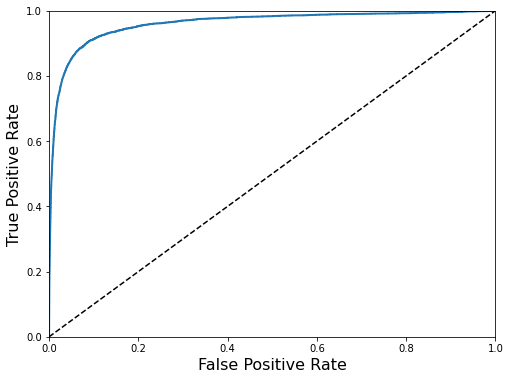

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

Quando escolhemos um valor específico de threshold para nosso classificador fixamos o ponto de trabalho deste na curva ROC. 

**Pergunta:** Um classificador perfeito opera em qual ponto do espaço (FPR, TPR)?

**R:**

```
Idealmente, deveria operar no ponto (0, 1): nenhum caso de false positive e todos os casos são true positive
```

**Curva ROC permite observar os possiveis valores de taxas de positivo verdadeiro e falso positivo, de modo a obter um valor (area sobre a curva) que representa a qualidade do cassificador, permitindo comparar classificadores (seja pelo desenho da curva, seja pelo score).**

O que acontece com um classificador aleatório (decide ao acaso o valor da função de decisão)? Este classificador terá uma curva ROC como a linha tracejada acima. Qualquer classificador melhor que aleatório terá uma curva ROC acima da linha tracejada.

Vamos trocar de classificador e ver o que acontece:

In [27]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba", n_jobs=-1)

# Gambiarra para desviar do bug #9589 introduzido no Scikit-Learn 0.19.0:
y_scores_forest = y_probas_forest[:, 1]  # score = prob. de ser da classe positiva

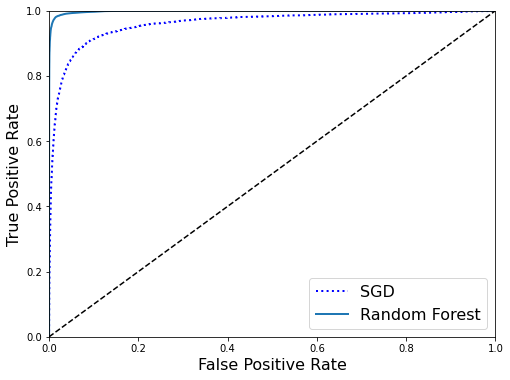

In [28]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [29]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba", n_jobs=-1)

# Gambiarra para desviar do bug #9589 introduzido no Scikit-Learn 0.19.0:
y_scores_forest_neg = y_probas_forest[:, 0]  # score = prob. de ser da classe negativa

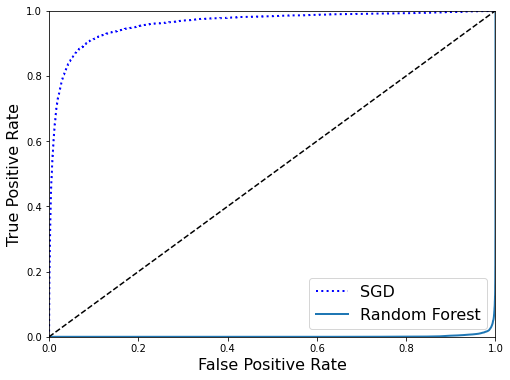

In [30]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest_neg)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Note que o classificador RandomForest apresenta TPR mais alto para um mesmo FPR do que o SGD. Com isso, parece que o RandomForest tem melhor desempenho que o SGD.

Para sumarizar o desempenho de um classificador binário em apenas um número, usamos a área sob a curva ROC (ROC AUC - Area Under the Curve - score). 

**Perguntas:** 

- Qual o valor do ROC AUC score para o classificador aleatório?

- Qual o valor do ROC AUC score para um classificador perfeito?

**R:**

```
Para o classificador aleatório, deve ser 50%.

Para o classificador perfeito, deve ser 100%
```

**Pergunta:**

O que você prefere ter: um classificador com $AUC = 0.75$ ou com $AUC = 0.1$? Justifique.

**R**:

```
É preferível ter um classificador com AUC = 0.1, pois mesmo estando invertendo as classes, há uma maior distinção na separação do que num classificador com AUC 0.75; O trecho abaixo ilustra essa justificativa.

"An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever."

```
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

Vamos então comparar os escores ROC AUC dos dois classificadores:

In [31]:
from sklearn.metrics import roc_auc_score

print('SGD: {:4f}'.format(roc_auc_score(y_train_5, y_scores)))
print('RandomForest: {:4f}'.format(roc_auc_score(y_train_5, y_scores_forest)))

SGD: 0.960494
RandomForest: 0.998344


RandomForest é um classificador melhor do que SGD neste problema. Veja também em termos da curva precision-recall:

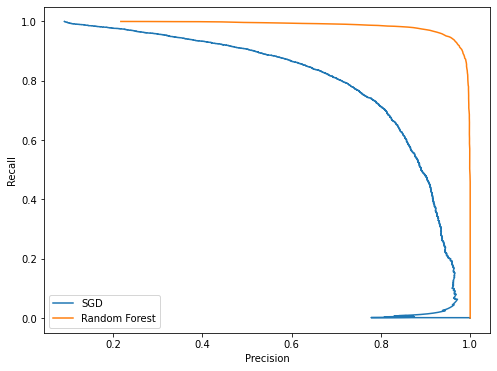

In [32]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(precisions, recalls, label='SGD')
plt.plot(precisions_forest, recalls_forest, label='Random Forest')
plt.legend(loc='lower left')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

De fato, o classificador RandomForest é superior ao classificador SGD em qualquer valor de precisão.

# Classificação multiclasse

Um classificador cinco-ou-não-cinco pode até ser útil, mas o problema real que queremos resolver é descobrir qual o dígito a partir de sua imagem. **Classificadores multiclasse** servem para este propósito.

Alguns algoritmos (como Random Forest) são intrinsecamente capazes de fazer classificação multi-classes. Outros são unicamente classificadores binários, como o SGD. 


In [33]:
forest_clf.fit(X_train, y_train)  # Aqui estamos usando y_train, não y_train_5!
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [34]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

O algoritmo RandomForest estima uma probabilidade de $90\%$ de que o dígito em questão seja um $5$, $1\%$ de que seja um $2$, $8\%$ de que seja um $3$ e $1\%$ de que seja um $9$ .

## One-versus-One e One-versus-All

Uma forma de fazer um classificador multi-classe à partir de um classificador exclusivamente binário é construir um classificador binário para cada classe, e comparar os scores resultantes de cada um. Como cada classificador é do tipo um-versus-outros, esta abordagem é conhecida como estratégia *one-versus-all* (OvA).

Outra possibilidade é treinar um conjunto de classificadores binários comparando classe-versus-classe. Por exemplo: no caso dos dígitos, teríamos o classificador zero-versus-um, zero-versus-dois, etc, até o classificador oito-versus-nove, para um total de 45 classificadores. Em geral, para um problema de $N$ classes temos $N \cdot (N - 1) / 2$ classificadores. Temos muito mais classificadores, mas cada um deles é treinado para resolver um problema muito mais específico (e.g. distinguir 5 de 7, ao invés de ter que distinguir 5 do resto). Ademais, o conjunto de treinamento de cada um destes classificadores especializados é muito menor.

Esta estratégia é conhecida como *one-versus-one* (OvO).

Quando usar qual deles (OvO versus OvA)? Alguns classificadores escalam mal com o número de amostras: nestes casos OvO é preferível. Em outros casos a simplicidade do OvA é melhor.

Scikit-learn usa automaticamente OvA para seus classificadores binários que não possam ser multiclasse automaticamente - exceto para Support Vector Machines, para os quais OvO é preferível por questão de escalabilidade.

In [35]:
sgd_clf = SGDClassifier(max_iter=500, tol=1e-3, random_state=RANDOM_SEED, n_jobs=-1)  # Existe aleatoriedade dentro do SGDClassifier.

sgd_clf.fit(X_train, y_train)  # Aqui estamos usando y_train, não y_train_5!
sgd_clf.predict([some_digit])

array([3], dtype=int8)

Para confirmar esse resultado, observe os valores da função de decisão para cada uma das classes:

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(sgd_clf.classes_)
print(some_digit_scores)

[0 1 2 3 4 5 6 7 8 9]
[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


Observe que o maior score corresponde à classe $5$ realmente.

**ATENÇÃO**: neste exercício temos uma coincidência: 

- A classe $0$ corresponde ao índice 0 no vetor de classes.
- A classe $1$ corresponde ao índice 1 no vetor de classes.
- ... e assim por diante.

Trata-se de uma coincidência! Se as classes fossem "cadeira", "mesa" e "chapeu" essa coincidência não existiria.

Se você tem um classificador binário qualquer (você fez o seu próprio classificador, por exemplo) e quer usá-lo em classificação multiclasse, o scikit-learn já tem classes auxiliares para transformar seu classificador binário em OvO ou OvA:

In [37]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=RANDOM_SEED))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [38]:
len(ovo_clf.estimators_)

45

## Métricas de desempenho

Assim como no caso dos classificadores binários, estamos interessados em estimar a performance real dos nossos classificadores multiclasse:

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

Nada mal: um classificador aleatório teria apenas um desempenho médio de 10% de acurácia!

Podemos melhorar o desempenho do classificador usando todos os truques das aulas passadas (GridSearch, scaling, data augmentation, etc). Por exemplo:

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.9036 , 0.90085, 0.9083 ])

## Análise de erro

Bom, você já usou todos os truques básicos do nosso arsenal, e agora tem um modelo que é o melhor que você conseguiu até o momento. Para avançar mais, temos que mergulhar mais a fundo na análise dos erros que nosso classificador está fazendo.

Uma primeira abordagem para a análise fina dos erros é a matriz de confusão:

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5612,    0,   25,    7,    9,   53,   39,    6,  171,    1],
       [   1, 6421,   40,   28,    5,   46,    4,    8,  174,   15],
       [  27,   28, 5275,   97,   74,   32,   69,   40,  304,   12],
       [  27,   21,  122, 5285,    2,  219,   27,   42,  308,   78],
       [  12,   15,   51,   12, 5245,   12,   42,   28,  236,  189],
       [  32,   17,   35,  180,   53, 4544,   78,   17,  393,   72],
       [  32,   16,   47,    2,   44,   99, 5572,    3,  102,    1],
       [  21,   12,   56,   35,   51,   12,    3, 5713,  119,  243],
       [  21,   68,   46,   95,    4,  130,   32,   11, 5385,   59],
       [  27,   20,   31,   71,  125,   41,    1,  181,  249, 5203]],
      dtype=int64)

Uma visualização gráfica pode ser mais efetiva:

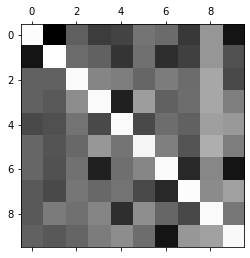

In [42]:
plt.matshow(np.log(1+conf_mx), cmap=plt.cm.gray)
plt.show()

Como esperado, a maior parte das predições é correta, e portanto a diagonal da matriz de confusão se sobressai. Para ressaltar os erros, vamos fazer o seguinte:

- Normalizar as linhas pela soma dos valores da linha.
- Zerar os elementos da diagonal, para facilitar a visualização dos erros.

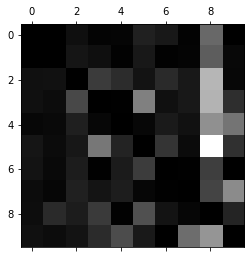

In [43]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(np.log(1+norm_conf_mx), cmap=plt.cm.gray)
plt.show()

Agora está mais claro: parece que temos muitos $5$ que são classificados como $3$ e vice-versa! Temos também vários $5$ classificados como $8$, mas o reverso é menos presente.

Pode ser ilustrativo observar alguns exemplos específicos de erro:

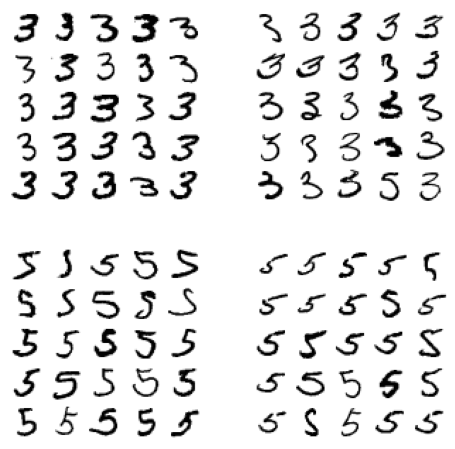

In [44]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Alguns erros são compreensíveis (digitos que de fato se parecem tanto com 3 como com 5), outros exemplos são misteriosos, como alguns digitos que são claramente 5 e foram classificados como 3. Por que um dígito que tão claramente se parece com um 5 foi classificado como 3? 

A resposta está no tipo de classificador usado. O SGDClassifier é um modelo linear: uma mera ponderação linear dos valores dos píxels. Se dois dígitos diferem apenas por poucos pixels, é fácil confundí-los.

**Atividade**: Agora que você tem um modelo treinado, avalie a acurária do modelo no conjunto de treinamento.

In [45]:
accuracy_array = cross_val_score(sgd_clf, X_test, y_test, cv=10, scoring='accuracy', n_jobs=-1)
print(accuracy_array)
np.mean(accuracy_array)

[0.869 0.82  0.859 0.839 0.848 0.897 0.87  0.899 0.929 0.891]


0.8721

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)
y_test_pred = sgd_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[ 902,    0,    8,   11,    1,   13,    2,    4,   39,    0],
       [   0, 1095,    2,    3,    0,    2,    4,    1,   28,    0],
       [   1,   10,  803,   69,    6,    4,    4,   10,  122,    3],
       [   0,    1,    6,  931,    1,   21,    3,    7,   35,    5],
       [   2,    2,    9,   15,  778,    4,    2,    9,   62,   99],
       [   6,    2,    1,   71,    3,  709,   12,   12,   67,    9],
       [   5,    3,   12,   13,    5,   21,  854,    0,   45,    0],
       [   0,    3,   18,   20,    3,    4,    1,  919,   18,   42],
       [   3,    5,    2,   30,    4,   43,    5,    5,  872,    5],
       [   3,    5,    2,   33,    7,    5,    0,   20,   57,  877]],
      dtype=int64)

acuracia = Soma_diag_principal/total

In [47]:
acc_top = 0
acc_bot = 0
for i in range(len(conf_mx)):
    for j in range(len(conf_mx)):
        if i == j:
            acc_top += conf_mx[i][j]
        acc_bot += conf_mx[i][j]
        
print(f"accuracy_test = {(acc_top/acc_bot).round(5)}")

accuracy_test = 0.874


In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

0.874

**Atividades:** Faça os problemas 1 e 2 do capítulo 3 do livro texto (Géron). **NÃO PRECISA ENTREGAR**

**Desafio:** Problema 4 do livro texto (Géron)! **NÃO PRECISA ENTREGAR**